In [69]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())

import wfg
import numpy as np
from tqdm import tqdm
import n_sphere
import matplotlib.pyplot as plt
from testsuite.utilities import Pareto_split, get_target_igd_refpoints
from scipy.spatial import distance_matrix

In [2]:
def attainment_sample(Y, Nsamples=1000):
    """
    Return samples from the attainment surface defined by the mutually non-dominating set Y

    Parameters
    ---------
    Y : array_like
        The surface to be sampled. Each row of Y is vector, that is mutually
        with all the other rows of Y
    Nsamples : int
        Number of samples

    Returns
    -------
    S : ndarray
        Array of samples from the attainment surface.
        Shape; Nsamples by Y.shape[1] 
    
    Notes
    -----
    See "Dominance-based multi-objective simulated annealing"
    Kevin Smith, Richard Everson, Jonathan Fieldsend, 
    Chris Murphy, Rashmi Misra.
    IEEE Transactions on Evolutionary Computing. 
    Volume: 12, Issue: 3, June 2008.
    https://ieeexplore.ieee.org/abstract/document/4358782
    """
    N, D = Y.shape
    Ymin = Y.min(axis=0)
    r = Y.max(axis=0) - Ymin
    S = np.zeros((Nsamples, D))
    
    # Set up arrays of the points sorted according to each coordinate.
    Ys = np.zeros((N, D))
    for d in range(D):
        Ys[:,d] = np.sort(Y[:,d])

    for n in tqdm(range(Nsamples)):
        v = np.random.rand(D)*r + Ymin
        m = np.random.randint(D)

        # Bisection search to find the smallest v[m] 
        # so that v is weakly dominated by an element of Y
        lo, hi = 0, N
        while lo < hi:
            mid = (lo+hi)//2
            v[m] = Ys[mid,m]
            if not any(weak_dominates(Y, v)):
                lo = mid+1
            else:
                hi = mid
        if lo == N: lo -= 1
        v[m] = Ys[lo, m]      
        assert lo == N-1 or any(weak_dominates(Y, v))
        S[n,:] = v[:]
    return S

def weak_dominates(Y, x):
    """
    Test whether rows of Y weakly dominate x
    
    Parameters
    ----------
    Y : array_like
        Array of points to be tested. 
        
    x : array_like
        Vector to be tested
        
    Returns
    -------
    c : ndarray (Bool)
        1d-array.  The ith element is True if Y[i] weakly dominates x
    """
    return (Y <= x ).sum(axis=1) == Y.shape[1]



In [3]:
def cartesian_to_spherical(x):
    """
    converts n-dimensional, cartesian coordinates x into 
    polar coordinates
    """
    assert x.ndim == 1
    r = np.linalg.norm(x)
    n = x.shape[0]-1
    
    phi_n_1 = np.arccos(x[n-1]/(np.sqrt(np.sum(x[n-1:]**2))))
    if x[-1]< 0:
        phi_n_1 = (2*np.pi)-phi_n_1
        
    phi_n_2 = np.arccos(x[n-2]/(np.sqrt(np.sum(x[n-2:]**2))))
    
    phi = [np.arccos(x[i]/np.sqrt(np.sum(x[i:]**2))) for i in range(n-2)]
    return np.array([*phi, phi_n_2, phi_n_1]), r

def spherical_to_cartesian(phis, r):
    """
    converts n-1 dimensional array of angles phis, and radius
    r into n-dimensional cartesian coordinates
    """
    phis= np.array(phis)
    n = phis.shape[0]+1
    
    x_n = r*np.product(np.sin(phis))
    x_n_1 = r*np.product(np.sin(phis[:-1]))*np.cos(phis[-1])
    
    xs = [r*np.cos(phis[i])*np.prod(np.sin(phis[:i]))for i in range(n-2)]
    
    return np.array([*xs, x_n_1, x_n])

In [4]:
def gen_points(prob_n, n_obj, kfactor, lfactor, n_points):

    M = n_obj
    k = kfactor*(M-1)   # position related params
    l = lfactor*2       # distance related params
    
    n_dim = k+l
    n_obj = M
    func = getattr(wfg, 'WFG{}'.format(int(prob_n)))

    N = n_points
    y = np.zeros((N, n_obj))
    x = np.zeros((N, n_dim))
    for n in range(N):
        z = wfg.random_soln(k, l, func.__name__)
        y[n,:] = func(z, k, M)
        x[n,:] = z
    print("{} parameters".format(z.shape))
    return y

In [5]:
def find_points_from_angles(points, angles):
    # deg to rads
    angles = np.array(angles)*np.pi/180
    
    # gen ref vector against whichy to measure angles, using dot product 
    ref_point = spherical_to_cartesian(angles, 1.)
    
    # normalise length of points
    points_norm = points/np.linalg.norm(points, axis=1).reshape(-1,1)
    
    cos_point_angles = np.array([np.dot(point, ref_point) for point in points_norm])
    
    return np.argmax(cos_point_angles)
    

In [6]:
y2_ref = gen_points(prob_n=1, n_obj=2, kfactor=2, lfactor=2, n_points=50000)
# y2_ref = Pareto_split(y2_ref)[0]
y2 = attainment_sample(y2_ref, 1000)
# y2 = np.load('../../comp/igd_refpoints/problem_refpoints/data/wfg1_2d_refpoints')
# y2, d = Pareto_split(y2_ref)

  0%|          | 2/1000 [00:00<01:21, 12.19it/s]

(6,) parameters


100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


In [7]:
t_ind_0 = find_points_from_angles(y2, [33])
t_ind_1 = find_points_from_angles(y2, [80])

targets_2d = np.array([np.array(np.round(t, 2))*m for t in [y2[t_ind_0], y2[t_ind_1]] for m in [0.8, 1.0, 1.2]])
targets_2d

array([[1.28 , 0.832],
       [1.6  , 1.04 ],
       [1.92 , 1.248],
       [0.4  , 2.264],
       [0.5  , 2.83 ],
       [0.6  , 3.396]])

(0.14177051324709392,
 2.3219257219323195,
 0.040238871492126266,
 4.433952556978469)

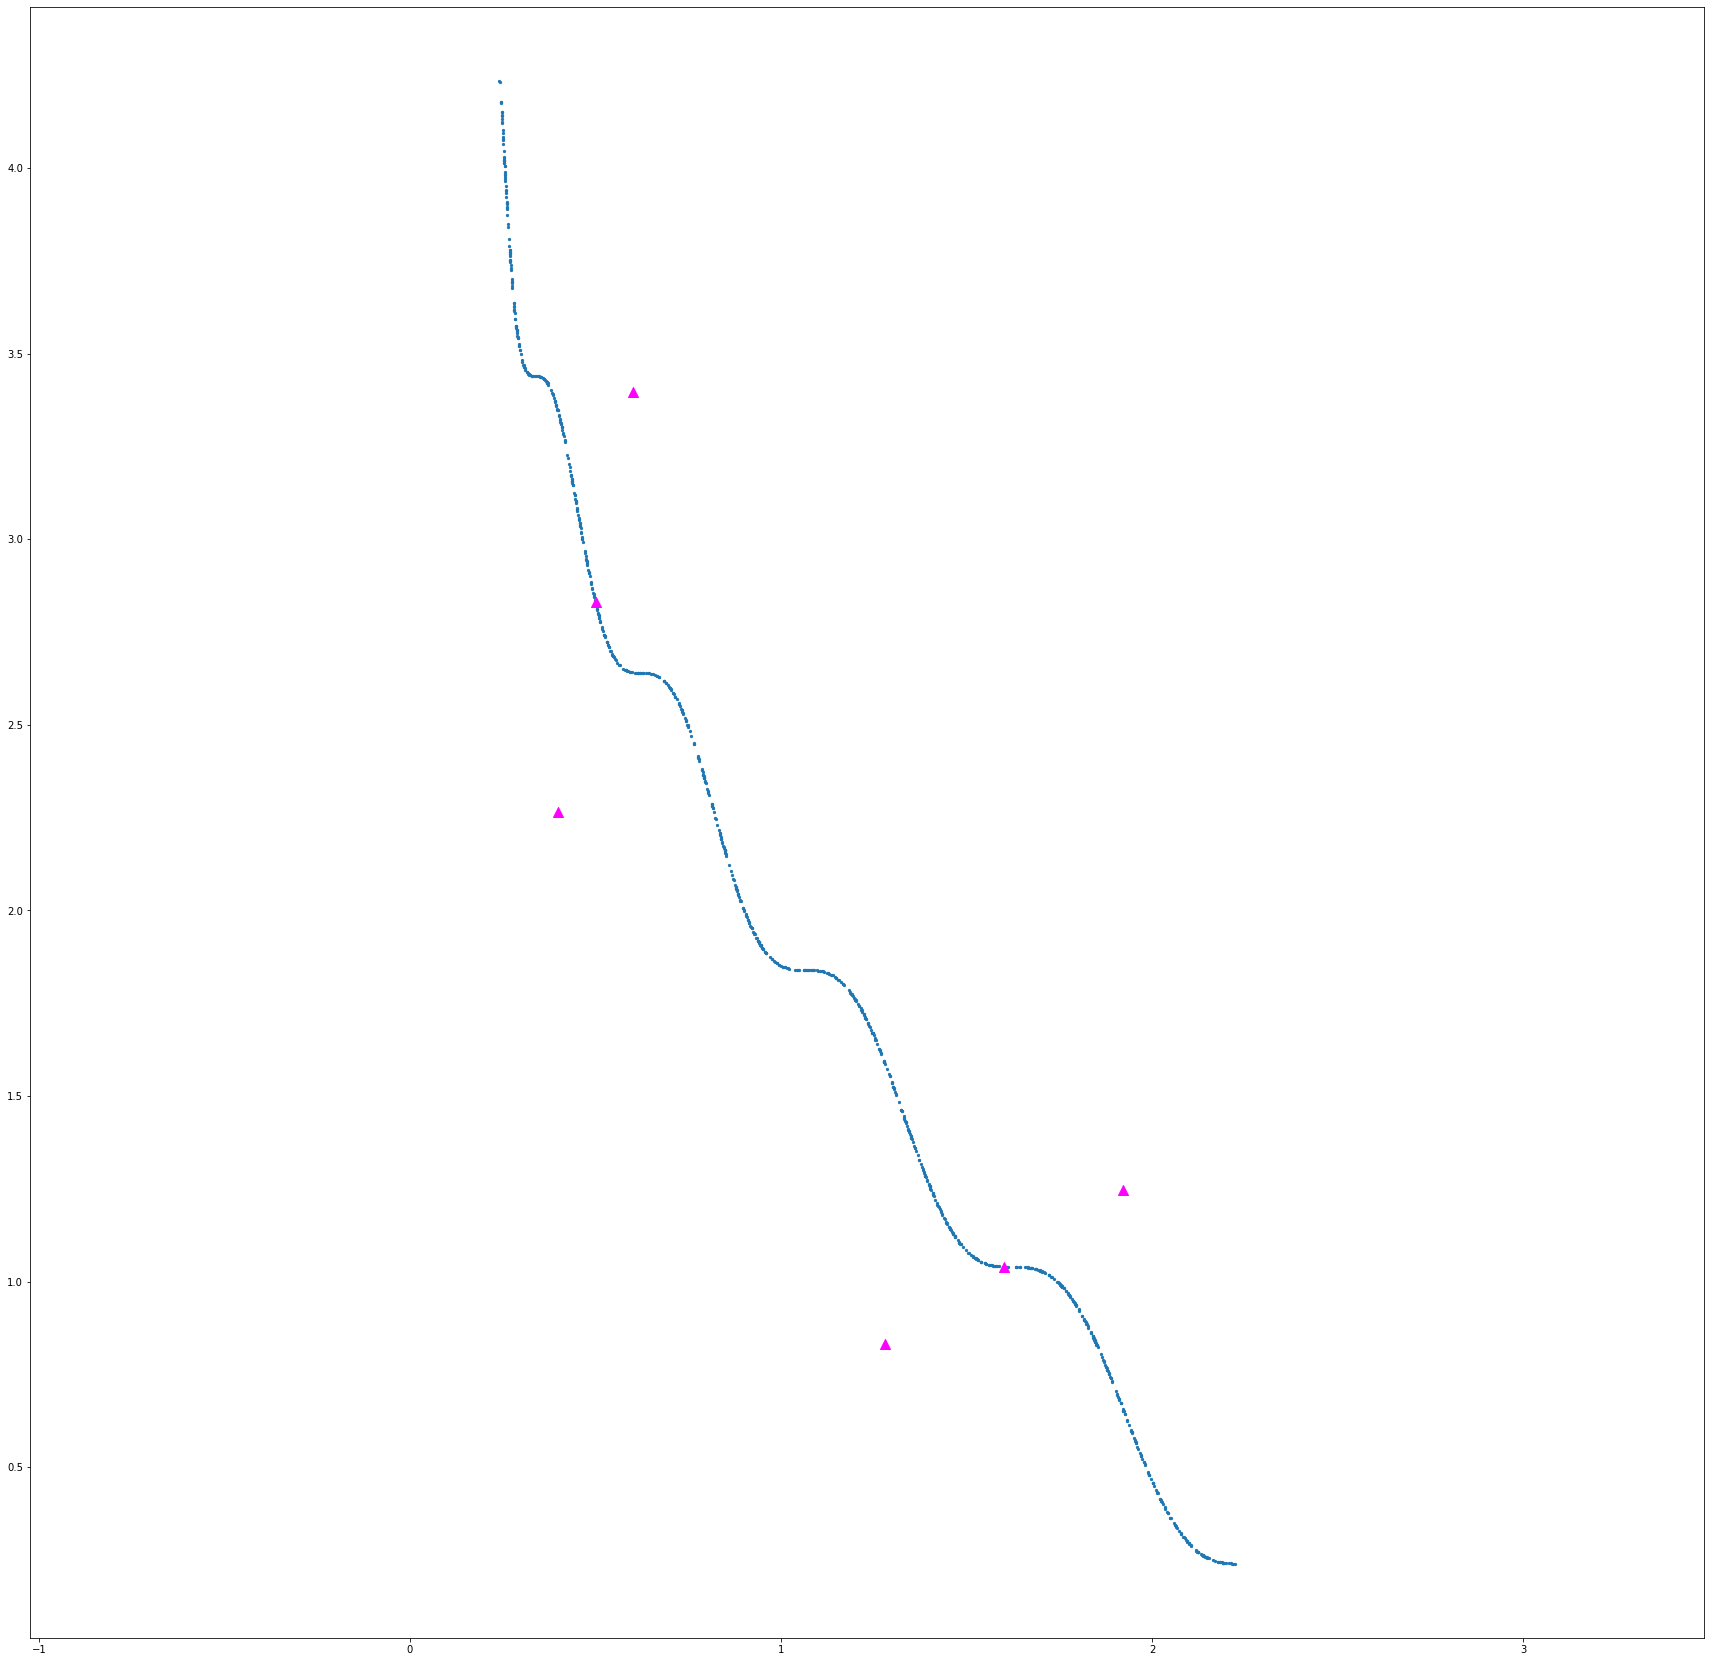

In [8]:
fig = plt.figure(figsize=[30,30])
ax = fig.gca()
ax.scatter(*y2.T, s=5)

ax.scatter(*targets_2d.T, c="magenta", marker="^", s=100)
ax.axis('equal')

[]


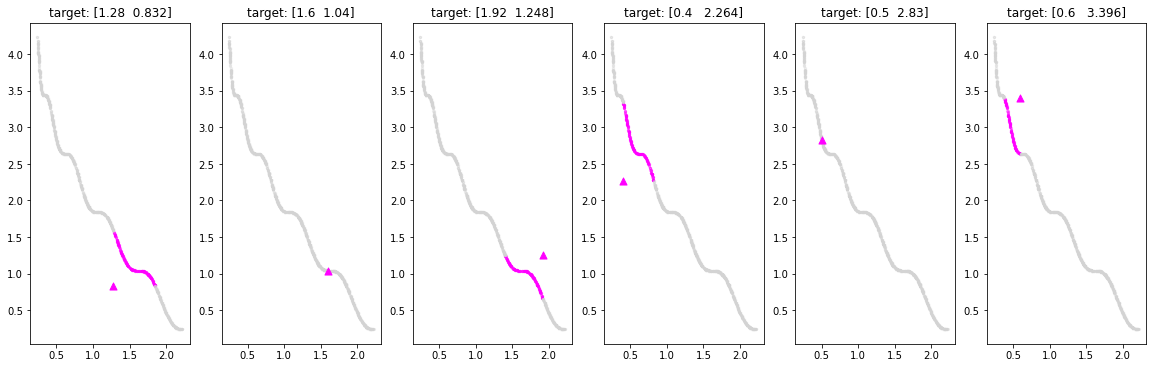

In [12]:
fig = plt.figure(figsize=[20,10])
ax0 = fig.add_subplot(161)
ax1 = fig.add_subplot(162, sharex=ax0, sharey=ax0)
ax2 = fig.add_subplot(163, sharex=ax0, sharey=ax0)
ax3 = fig.add_subplot(164, sharex=ax0, sharey=ax0)
ax4 = fig.add_subplot(165, sharex=ax0, sharey=ax0)
ax5 = fig.add_subplot(166, sharex=ax0, sharey=ax0)

for t, ax in zip(targets_2d, fig.axes):
    igd_points, other_points = get_target_igd_refpoints(t, y2) 
    try:
        ax.scatter(*igd_points.T, s=5, c="magenta", alpha=0.3)
    except TypeError:
        print(igd_points)
        pass
    ax.scatter(*other_points.T, s=5, c="lightgrey", alpha=0.3)
    ax.scatter(*t, s=50, marker="^", c="magenta")
    ax.set_title("target: {}".format(t))
    ax.set_aspect('equal')

In [19]:
target_dict = {'WFG1_{}obj_{}dim'.format(targets_2d.shape[1], 6): targets_2d.tolist()}
target_dict

{'WFG1_2obj_6dim': [[1.2800000000000002, 0.8320000000000001],
  [1.6, 1.04],
  [1.92, 1.248],
  [0.4, 2.2640000000000002],
  [0.5, 2.83],
  [0.6, 3.396]]}

In [20]:
import json
with open('./targets/WFG1_targets.txt', 'w') as outfile:
    json.dump(target_dict, outfile)

# 3D

In [21]:
y3_ref = gen_points(prob_n=1, n_obj=3, kfactor=1, lfactor=2, n_points=50000)
# y3_ref = Pareto_split(y3_ref)[0]
y3 = attainment_sample(y3_ref, 10000)
y3.shape

  0%|          | 2/10000 [00:00<10:18, 16.16it/s]

(6,) parameters


100%|██████████| 10000/10000 [08:22<00:00, 19.89it/s]


(10000, 3)

<ipython-input-22-10b9ab78ae70>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig0.show()


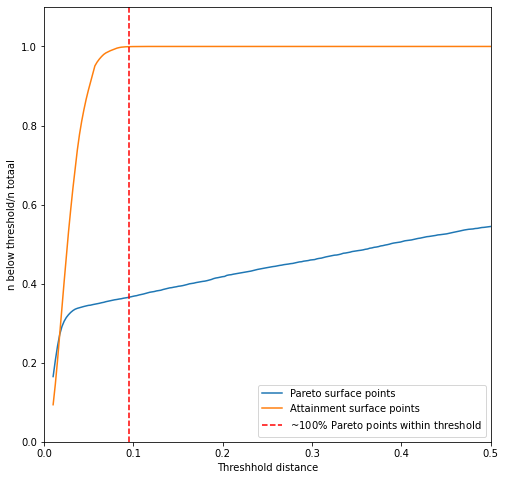

In [22]:
def threshold_sample(y, ya, thresh):
    D = distance_matrix(y, ya)
    
    min_D0 = D.min(axis=0)
    min_D1 = D.min(axis=1)
    
    thresh_plot_0 = [sum(min_D0<i) for i in np.linspace(0.01, 0.5, 200)]
    thresh_plot_1 = [sum(min_D1<i) for i in np.linspace(0.01, 0.5, 200)]
    
    fig0 = plt.figure(figsize=[8, 8])
    fig0_ax = fig0.gca()
    fig0_ax.plot(np.linspace(0.01, 0.5, 200), np.array(thresh_plot_0)/len(min_D0), label="Pareto surface points")
    fig0_ax.plot(np.linspace(0.01, 0.5, 200), np.array(thresh_plot_1)/len(min_D1), label="Attainment surface points")
    fig0_ax.axvline(thresh, linestyle="--", c="r", label=r"~$100\%$ Pareto points within threshold")
    fig0_ax.set_xlabel("Threshhold distance")
    fig0_ax.set_ylabel("n below threshold/n totaal")
    fig0_ax.set_xlim([0, 0.5])
    fig0_ax.set_ylim([0, 1.1])
    fig0_ax.legend()
    fig0.show()
    
    return ya[min_D0<thresh]

ans0 = threshold_sample(y3_ref, y3, thresh=0.095)
ans = ans0[:2000]

In [74]:
fig = plt.figure(figsize=[18, 8])
ax0 = fig.add_subplot(121, projection="3d")
ax1 = fig.add_subplot(122, projection="3d")

included =[np.sum((yq == ans0).sum(axis=1)==3, dtype=bool) for yq in y3]
included = y3[included]
excluded =[np.logical_not(np.sum((yq == ans0).sum(axis=1)==3, dtype=bool)) for yq in y3]
excluded = y3[excluded]

ax0.scatter(*y3.T, s=2, label="original points", c="C0")
ax1.scatter(*included.T, s=2, label="included", c="C1")
ax1.scatter(*excluded.T, s=2, label="excluded", c="C0")

ax0.view_init(elev=35., azim=25)
ax1.view_init(elev=25., azim=15)

In [76]:
y3 = ans
t_ind_0 = find_points_from_angles(y3, [80, 65])
t_ind_1 = find_points_from_angles(y3, [33, 33])

targets_3d = np.array([np.array(np.round(t, 2))*m for t in [y3[t_ind_0], y3[t_ind_1]] for m in [0.8, 1.0, 1.2]])
targets_3d

array([[0.368, 0.848, 1.8  ],
       [0.46 , 1.06 , 2.25 ],
       [0.552, 1.272, 2.7  ],
       [0.968, 0.536, 0.352],
       [1.21 , 0.67 , 0.44 ],
       [1.452, 0.804, 0.528]])

In [77]:
with open('./targets/WFG1_targets.txt', 'r') as infile:
    target_dict = json.load(infile)
target_dict['WFG1_{}obj_{}dim'.format(3, 6)] = targets_3d.tolist()

with open('./targets/WFG1_targets.txt', 'w') as outfile:
    json.dump(target_dict, outfile)

In [78]:
%matplotlib qt

In [79]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection="3d")
ax.set_box_aspect((2, 4, 6))

ax.scatter(*y3.T, s=5, alpha=0.2)
ax.scatter(*targets_3d.T, c="magenta", marker="^")
ax.view_init(35,15)

In [83]:
fig = plt.figure(figsize=[20,20])
ax0 = fig.add_subplot(231, projection='3d')
ax1 = fig.add_subplot(232, projection='3d')
ax2 = fig.add_subplot(233, projection='3d')
ax3 = fig.add_subplot(234, projection='3d')
ax4 = fig.add_subplot(235, projection='3d')
ax5 = fig.add_subplot(236, projection='3d')

fig.tight_layout()

for t, ax in zip(targets_3d, fig.axes):
    ax.set_box_aspect((2, 4, 6))
    igd_points, other_points = get_target_igd_refpoints(t, y3) 
    try:
        ax.scatter(*igd_points.T, s=5, c="magenta", alpha=0.3)
    except TypeError:
        print(igd_points)
        pass
    ax.scatter(*other_points.T, s=5, c="lightgrey", alpha=0.3)
    ax.scatter(*t, s=50, marker="^", c="magenta")
    ax.set_title("target: {}".format(t))
    ax.view_init(35, 15)

[]


### 4D

In [84]:
# y4 = gen_points(prob_n=4, n_obj=4, kfactor=2, lfactor=2, n_points=100000)
y4 = np.load('../../comp/igd_refpoints/problem_refpoints/data/wfg1_4d_refpoints')
y4, y4d = Pareto_split(y4)
y4.shape

(3195, 4)

In [85]:
t_ind = find_points_from_angles(y4, [80, 30, 30])
t_ind2 = find_points_from_angles(y4, [33, 33, 65])

targets_4d = np.array([np.array(np.round(t, 2))*m for t in [y4[t_ind_0], y4[t_ind_1]] for m in [0.8, 1.0, 1.2]])
targets_4d

array([[0.536, 0.232, 1.288, 0.456],
       [0.67 , 0.29 , 1.61 , 0.57 ],
       [0.804, 0.348, 1.932, 0.684],
       [0.336, 1.208, 0.456, 0.296],
       [0.42 , 1.51 , 0.57 , 0.37 ],
       [0.504, 1.812, 0.684, 0.444]])

In [88]:
fig = plt.figure(figsize=[10, 10]) 
ax0 = fig.add_subplot(231)
ax1 = fig.add_subplot(232)
ax2 = fig.add_subplot(233)
ax3 = fig.add_subplot(234)
ax4 = fig.add_subplot(235)
ax5 = fig.add_subplot(236)


for t, ax in zip(targets_4d, fig.axes):
    igd_points, other_points = get_target_igd_refpoints(t, y4) 
    ax.scatter(*igd_points[:,:2].T, s=5, c="magenta", alpha=0.3)
    ax.scatter(*other_points[:,:2].T, s=5, c="lightgrey", alpha=0.3)
    ax.scatter(*t[:2], s=50, marker="^", c="magenta")
    ax.set_title("target: {}".format(t))

IndexError: too many indices for array

In [87]:
for t in targets_4d:
    igd_points, other_points = get_target_igd_refpoints(t, y4) 
    print('Target {}:\t {}/{}'.format(t, igd_points.shape[0], other_points.shape[0]))

Target [0.536 0.232 1.288 0.456]:	 35/3160
Target [0.67 0.29 1.61 0.57]:	 0/3195
Target [0.804 0.348 1.932 0.684]:	 21/3174
Target [0.336 1.208 0.456 0.296]:	 32/3163
Target [0.42 1.51 0.57 0.37]:	 0/3195
Target [0.504 1.812 0.684 0.444]:	 27/3168
